In [47]:
%reset -f

In [48]:
%tensorflow_version 2.x

# Cargar librerias

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os
from random import randrange, uniform

In [49]:
# Borrar copia del repositorio
try:
  import shutil
  shutil.rmtree('/content/FutureFest')
except:
  None

In [50]:
!git clone https://github.com/aldofranco91/FutureFest /content/FutureFest

Cloning into '/content/FutureFest'...
remote: Enumerating objects: 909, done.
remote: Counting objects: 100% (909/909), done.
remote: Compressing objects: 100% (897/897), done.
remote: Total 909 (delta 25), reused 866 (delta 10), pack-reused 0
Receiving objects: 100% (909/909), 57.03 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [51]:
def apply_damage(image):
    img = cv2.imread(image)
    for i in range(0,randrange(8,13)):
      x1, y1 = randrange(0,255), randrange(0,255)
      x2, y2 = randrange(0,255), randrange(0,255)
      color_linea = (randrange(0,255),randrange(0,255),randrange(0,255))
      line_thickness = randrange(1,3)
      img = cv2.line(img, (x1, y1), (x2, y2), color_linea, thickness=line_thickness)  
    return img

PATH = "/content/FutureFest/Pix2Pix"  # Ruta raíz
INPATH = PATH + '/input' # Ruta datos de entrada
OUPATH = PATH + '/target_reducido' # Ruta datos de salida
OUTPUT = PATH + '/output' # Ruta guardar progreso

os.mkdir(INPATH) #Crear las carpeta input
os.mkdir(OUTPUT) #Crear las carpeta output

filenames = os.listdir(OUPATH)

In [52]:
index = 0 
for i in filenames: 
    ruta_in = OUPATH + '/' + i
    ruta_out = INPATH + '/' + i
    imagen_salida = apply_damage(ruta_in)
    cv2.imwrite(ruta_out,imagen_salida)
    index += 1

total_imagenes = len(filenames)
print("Total de imagenes: " + str(total_imagenes))

Total de imagenes: 572


In [53]:
imgurls = !ls -1 "{INPATH}"

p = 0.1
train_n = int(total_imagenes*p) 

# Listado randomizado
randurls = np.copy(imgurls)
np.random.shuffle(randurls)

# Partición train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[-(total_imagenes-train_n):]

print(len(imgurls), len(tr_urls), len(ts_urls))

572 57 515


In [54]:
IMG_WIDTH = 256; IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  tgimg = tf.image.resize(tgimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return inimg, tgimg

# Normalizar [-1, 1]
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  return inimg, tgimg

def load_image(filename):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)[...,:3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)),tf.float32)[...,:3]
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  inimg, tgimg = normalize(inimg, tgimg)
  return inimg, tgimg

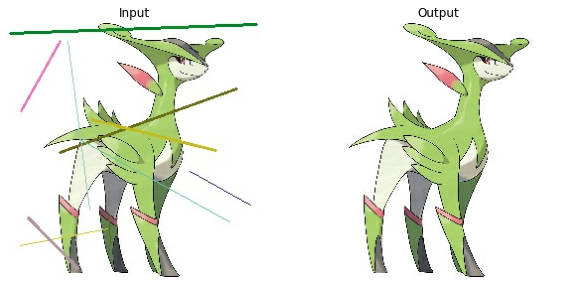

In [55]:
x = randrange(0,train_n)
display_list = [ ((load_image(randurls[x])[0] + 1)/2) , ((load_image(randurls[x])[1] + 1)/2)]
plt.figure(figsize=(10,10))
title = ['Input', 'Output']
for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i])
      plt.axis('off')

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [57]:
def downsample(filters, size, apply_batchnorm=True):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)
  # Capa convolucional
  result.add(tf.keras.layers.Conv2D(filters, kernel_size = size, strides = 2, padding = 'same', kernel_initializer=initializer, use_bias=not apply_batchnorm))
  # Capa de BatchNorm                                     
  if apply_batchnorm: result.add(tf.keras.layers.BatchNormalization()) 
  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):
  result = tf.keras.Sequential()
  initializer = tf.random_normal_initializer(0., 0.02)
  # Capa convolucional
  result.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size = size, strides = 2, padding = 'same', kernel_initializer=initializer, use_bias=False))
  # Capa de BatchNorm
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout: result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [58]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(filters = 3,kernel_size = 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 3)
  concat = tf.keras.layers.Concatenate()
  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  last = last(x)
  return tf.keras.Model(inputs=inputs, outputs=last)

generator = Generator()

In [59]:
def Discriminator():
  
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
  down4 = downsample(512, 4)(down3) # (bs, 32, 32, 512)

  last = tf.keras.layers.Conv2D(filters = 1,
                                kernel_size = 4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding = 'same')(down4) 
  
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

In [60]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [61]:
def generate_images(model, input, tar, file_name ,train_or_test, save_filename = False, display_imgs = True):
  prediction = model(input, training=True)
  if save_filename: tf.keras.preprocessing.image.save_img(PATH + '/output/' + file_name + '.jpg', prediction[0,...])
  
  plt.figure(figsize=(15,15))
  display_list = [input[0], tar[0], prediction[0]]

  if train_or_test == "train": title = ['Input Image Train', 'Image Truth Train', 'Predicted Image']
  if train_or_test == "test":  title = ['Input Image Test', 'Image Truth Test', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow((display_list[i] + 1)/2) # getting the pixel values between [0, 1] to plot it.
      plt.axis('off')
        
  plt.show()
  time.sleep(3)

In [62]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    output_image = generator(input_image, training=True)
    output_gen_discr = discriminator([output_image, input_image], training=True)
    output_trg_discr = discriminator([target, input_image], training=True)
    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    gen_loss = generator_loss(output_gen_discr, output_image, target)
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = disc_tape.gradient(discr_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))   
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

LAMBDA = 100 # Ver q es nuevo hiperparámetro lambda, p. ej. dando xx veces la
#importancia de la pérdida L1 que la pérdida adversaria para el generador durante el entrenamiento.

In [63]:
from IPython.display import clear_output
def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    # Train
    for input_image, target in dataset:
      print('Epoch ' + str(epoch) + '/' + str(epochs) + '- train:' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)
      clear_output(wait=True)
    
    imgi = 0
    for inp, tar in train_dataset.take(1):
      generate_images(generator, inp, tar, file_name = "train/" + str(imgi) + '_' + str(epoch), train_or_test= "train", save_filename=True, display_imgs=True)
      imgi += 1

    imgi = 0
    for inp, tar in test_dataset.take(1):
      generate_images(generator, inp, tar, file_name = "test/" + str(imgi) + '_' + str(epoch), train_or_test= "test", save_filename=True, display_imgs=True)
      imgi += 1

In [64]:
os.mkdir(OUTPUT + "/train")
os.mkdir(OUTPUT + "/test")

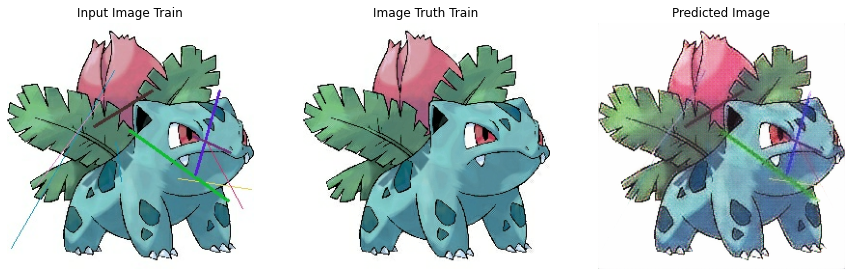

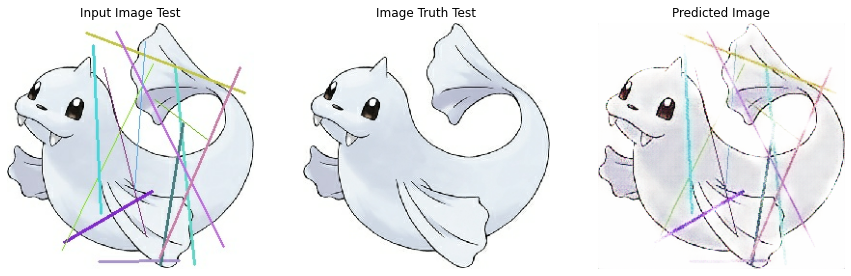

In [65]:
train(train_dataset, 10)

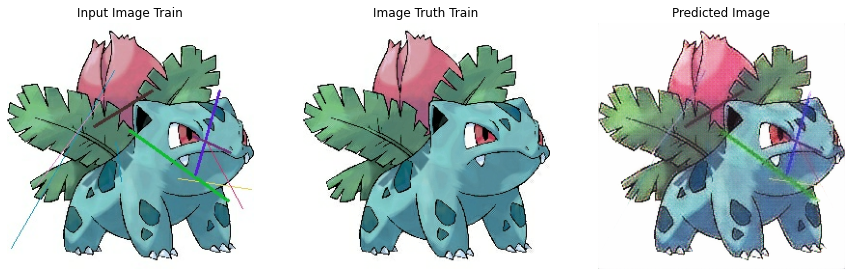

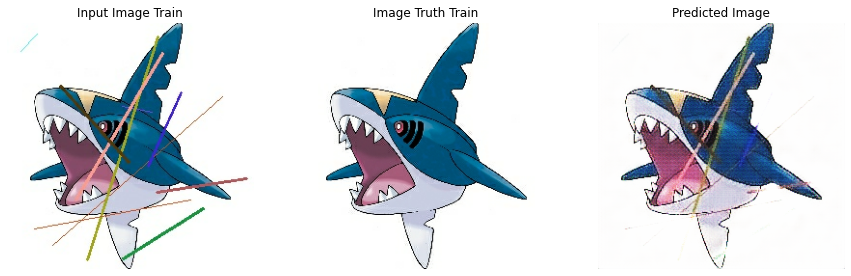

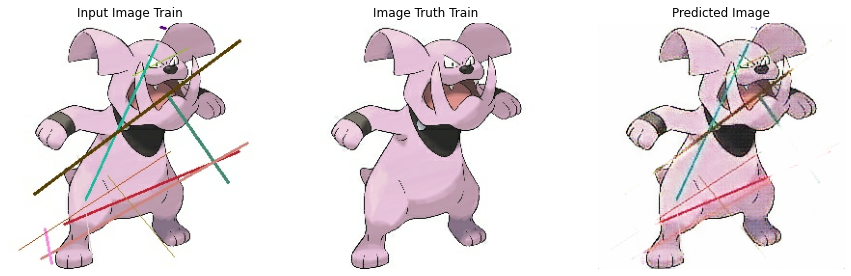

In [73]:
# Run the trained model on a few examples from the train dataset
for inp, tar in train_dataset.take(3): generate_images(generator, inp, tar, file_name = "None" , train_or_test = "train")

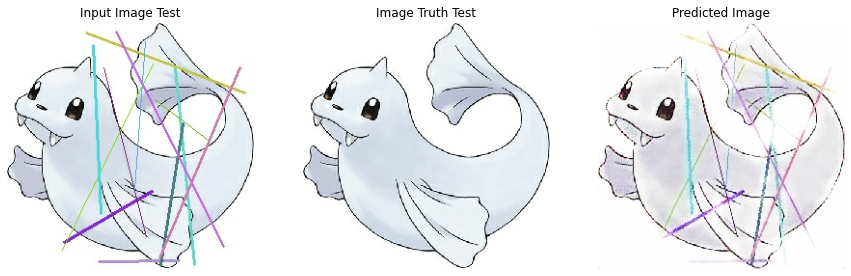

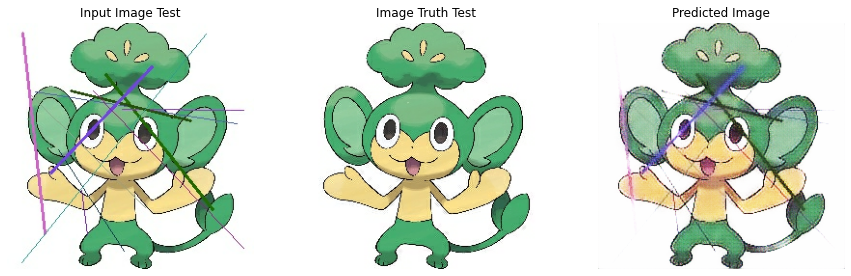

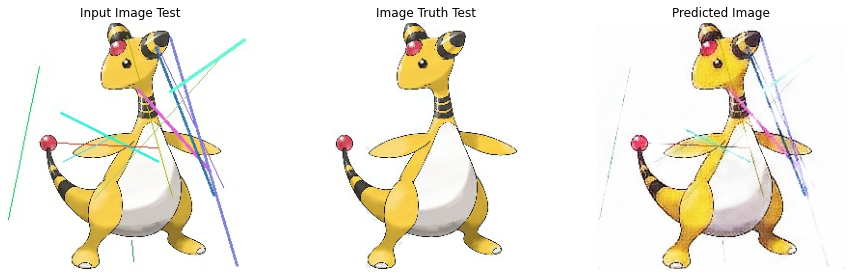

In [75]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(3): generate_images(generator, inp, tar, file_name = "None" , train_or_test = "test")

In [76]:
# Subir ejemplo a mano
IMG_WIDTH = 256; IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg, height, width):
  inimg = tf.image.resize(inimg, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return inimg

# Normalizar [-1, 1]
def normalize(inimg):
  inimg = (inimg / 127.5) - 1
  return inimg

def load_image(filename):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(filename)),tf.float32)[...,:3]
  inimg = resize(inimg, IMG_HEIGHT, IMG_WIDTH)
  inimg = normalize(inimg)
  return inimg

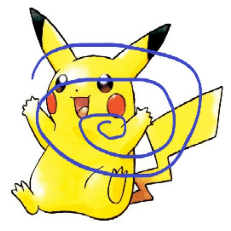

In [ ]:
ruta_caso_manual = "/content/mano.jpg"
img = ((load_image(ruta_caso_manual))) 
plt.imshow((img+1)/2)
plt.axis('off')    
plt.show()

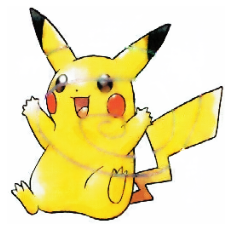

In [ ]:
prediction = generator(tf.reshape(img,[1,256,256,3]), training=True)
plt.imshow((prediction[0]+1)/2)
plt.axis('off')    
plt.show()